In [1]:
# -*- coding: utf-8 -*-
import cv2
import os
import sys
import time
import random
import json
import numpy as np
import torch
%matplotlib inline
import matplotlib.pyplot as plt
import ipdb
import pickle
from collections import OrderedDict, Counter

0 1577148525_71091170.jpg
1 1577150091_56664008.jpg
2 1577154403_44615878.jpg
3 1577150454_12549955.jpg
4 1577155949_10753067.jpg
5 1577154090_43829330.jpg
6 1577156395_73747665.jpg
7 1577154914_45671672.jpg
8 1577155784_98833102.jpg
9 1577156188_18047041.jpg
10 1577152231_27611256.jpg
11 1577147623_28595432.jpg
12 1577151826_45707562.jpg
13 1577147887_9732312.jpg
14 1577154800_69232538.jpg
15 1577150218_617222.jpg
16 1577154286_81296756.jpg
17 1577152664_9562992.jpg
18 1577155738_12312991.jpg
19 1577150414_47453603.jpg
20 1577151138_69815507.jpg
21 1577149492_76221612.jpg
22 1577150714_23199073.jpg
23 1577149534_12237769.jpg
24 1577150742_17540586.jpg
25 1577153179_79193371.jpg
26 1577150446_50147193.jpg
27 1577148032_45700283.jpg
28 1577148321_46601506.jpg
29 1577151412_28625682.jpg
30 1577151697_4893656.jpg
31 1577152440_1429575.jpg
32 1577150669_41031944.jpg
33 1577149476_49731502.jpg
34 1577153172_46145134.jpg
35 1577155795_10077590.jpg
36 1577152592_45202592.jpg
37 1577148952_709

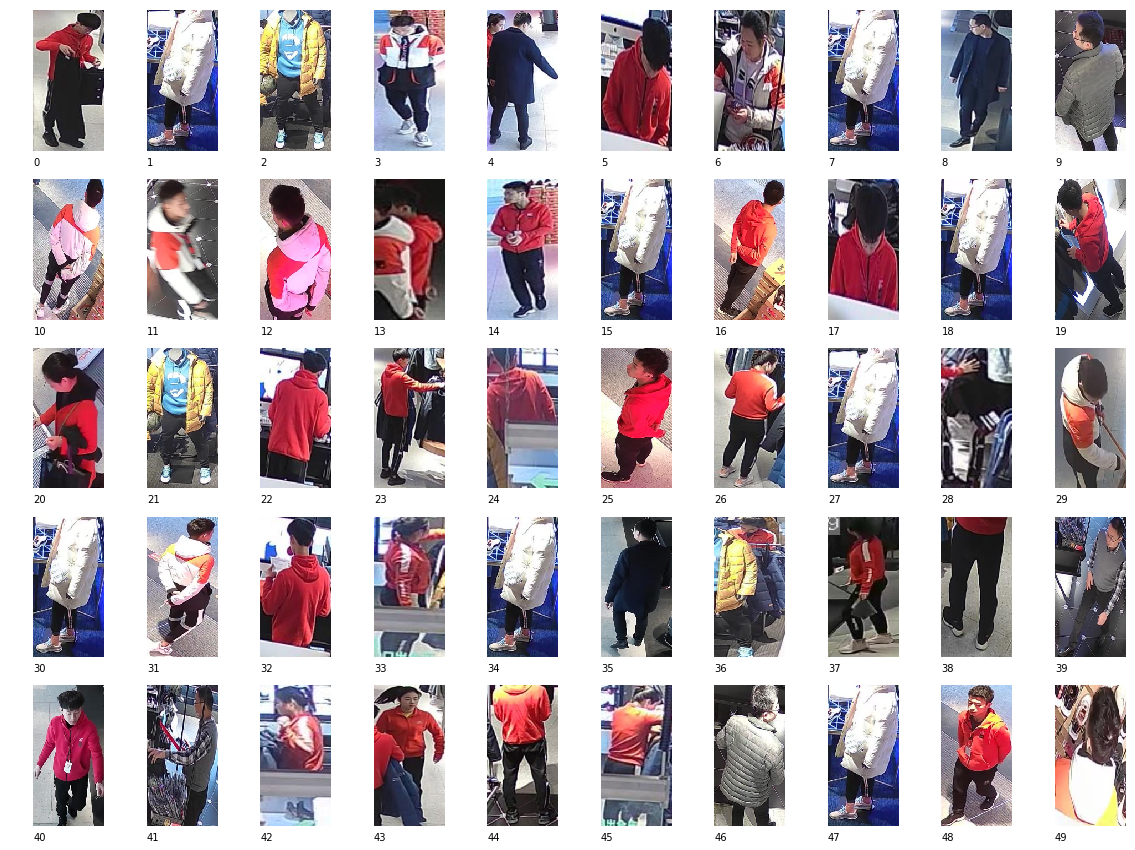

In [7]:
def random_show_imgdir(root):
    rows = 5
    cols = 10
    plt.figure(0, figsize=(cols*2, rows*3))
    path_list = []
    for i, basename in enumerate(os.listdir(root)):
        if i==rows*cols:break;
        path_list.append(basename)
        plt.subplot(rows, cols, i+1)
        img = cv2.resize(cv2.imread(os.path.join(root, basename)), (128, 256))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.text(0, img.shape[0]*1.1, '%s'%i) 
        plt.axis('off')
    for i, path in enumerate(path_list):print(i, path)
root = "/world/data-c40/liliang/clerk_24"
random_show_imgdir(root)

In [ ]:
class PthPredictInterface(object):
    def __init__(self, model_path):
        sys.path.insert(0,"/world/data-gpu-112/liliang/pytorch-reid")
        from utils import model_utils
        from nets.model_main import ft_net
        sub_working_dir = os.path.dirname(model_path)
        params = sorted([i for i in os.listdir(sub_working_dir) if 'params' in i])
        params_path = os.path.join(sub_working_dir, params[-1])
        config = json.load(open(params_path, "r"))
        config["parallels"] = [0]
        os.environ["CUDA_VISIBLE_DEVICES"] = str(config["parallels"])[1:-1]
        self.mean = np.reshape(np.array([0.485, 0.456, 0.406]),
                                         [1, 3, 1, 1])
        self.variance = np.reshape(np.array([0.229, 0.224, 0.225]),
                                             [1, 3, 1, 1])
        net_fn = ft_net
        net = net_fn(config, model_name=config["model_params"]["model"],
                 feature_dim=config["model_params"].get("feature_dim", 256),
                 pcb_n_parts=config["model_params"].get("pcb_n_parts", 0),
                 init_cls_layer=False)
        model_utils.restore_model(model_path, net, eval_mode=True)
        self.model = net.cuda(0)
        self.model.eval()
        self.config = config
        
    def preprocess_batch(self, batch):
        batch = [cv2.cvtColor(cv2.resize(img, (self.config["img_w"], self.config["img_h"])),
                              cv2.COLOR_BGR2RGB) for img in batch]
        batch = np.array(batch, dtype=np.float)
        batch /= 255.0
        batch = np.transpose(batch, [0, 3, 1, 2])
        batch = (batch - self.mean) / self.variance
        batch = torch.from_numpy(batch).float().cuda()
        return batch
    
    def predict(self, images):
        images = self.preprocess_batch(images)
        with torch.no_grad():
            rlt = self.model(images)
        return rlt
    
    def __call__(self, images):
        return self.predict(images)

def run_eval_pth(pretrain_snapshot, img_path_pair):
    print ("model restored form: %s" %pretrain_snapshot)
    model = PthPredictInterface(pretrain_snapshot)
    # forward
    imgs = []
    for i, path in enumerate(img_path_pair):
        image = cv2.imread(path)
        image = cv2.resize(image, (128,256)) 
        image = np.expand_dims(image, 0)
        imgs.append(image)
    imgs = np.concatenate(imgs, axis=0)
    embeddings = np.array(model.predict(imgs)[0].cpu())
    return embeddings

def run_eval_freeze(pretrain_snapshot, img_path_pair):
    from auto_deploy.predictor import Predictor
    print ("model restored form: %s" %pretrain_snapshot)
    model = Predictor(gpu=0, input_size=(128, 256), model_path=pretrain_snapshot,
                      preprocess_dict={"norm_lambda": "lambda x: x", "color_mode": "None"})
    # forward
    imgs = []
    for i, path in enumerate(img_path_pair):
        image = cv2.imread(path)
        image = cv2.resize(image, (128,256)) 
        image = np.expand_dims(image, 0)
        imgs.append(image)
    imgs = np.concatenate(imgs, axis=0)
    embeddings = np.array(model.predict(imgs)[0])
    return embeddings

def show_img_pair(img_path_pair):
    plt.figure(0, figsize=(8, 4))
    for i, path in enumerate(img_path_pair):
        plt.subplot(1, 2, i+1)
        img = cv2.resize(cv2.imread(path), (128, 256))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.text(0, img.shape[0]*1.05, 'path: %s'%os.path.basename(path)) 
        plt.axis('off')

def cal_similarity(embeddings):
    f_norm = np.linalg.norm(embeddings, axis=1, keepdims=True)
    f_norm = f_norm[0] * f_norm[1]
    cos_sim = np.dot(embeddings[0], embeddings[1].T)/f_norm
    return cos_sim[0]

# pretrain_snapshot = "/world/data-gpu-112/liliang/pytorch-output/cleanv12_resnet50_am035_am0_fixcls_v11/model_best.pth"
pretrain_snapshot = "/world/data-c7/liliang/pytorch_reid_models/v4-2-4-1.5tw.onnx"
img_path_pair = [
    "/world/data-c40/liliang/clerk_24/1577151138_69815507.jpg",
    "/world/data-c40/liliang/clerk_24/1577149534_12237769.jpg"
]
print(torch.cuda.is_available())
show_img_pair(img_path_pair)
embeddings = run_eval_freeze(pretrain_snapshot, img_path_pair)
# embeddings = run_eval_pth(pretrain_snapshot, img_path_pair)
cos_sim = cal_similarity(embeddings)
print("cos_similarity: %s"%cos_sim)

True
model restored form: /world/data-c7/liliang/pytorch_reid_models/v4-2-4-1.5tw.onnx
